# Predicting MHC-pTCR interactions

In [1]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import roc_curve, confusion_matrix
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_curve
from torch.autograd import Variable
from torch.nn.functional import relu, sigmoid
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

### Run code on gpu

In [3]:
# define device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device (CPU/GPU):", device)


Using device (CPU/GPU): cuda


### Load data 

Get data from github repository: https://github.com/JulieMariaJ/TCR-pMHC.git.

In [4]:
!wget https://raw.githubusercontent.com/JulieMariaJ/TCR-pMHC/main/data/P1_labels.npz
!wget https://raw.githubusercontent.com/JulieMariaJ/TCR-pMHC/main/data/P2_labels.npz
!wget https://raw.githubusercontent.com/JulieMariaJ/TCR-pMHC/main/data/P3_labels.npz
!wget https://raw.githubusercontent.com/JulieMariaJ/TCR-pMHC/main/data/P4_labels.npz

--2021-12-27 13:32:56--  https://raw.githubusercontent.com/JulieMariaJ/TCR-pMHC/main/data/P1_labels.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12472 (12K) [application/octet-stream]
Saving to: ‘P1_labels.npz’

P1_labels.npz       100%[===================>]  12.18K  --.-KB/s    in 0s      

2021-12-27 13:32:56 (43.7 MB/s) - ‘P1_labels.npz’ saved [12472/12472]

--2021-12-27 13:32:56--  https://raw.githubusercontent.com/JulieMariaJ/TCR-pMHC/main/data/P2_labels.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9608 (9.4K) [

In [5]:
!wget https://raw.githubusercontent.com/JulieMariaJ/TCR-pMHC/main/data/P1_input.npz.zip
!wget https://raw.githubusercontent.com/JulieMariaJ/TCR-pMHC/main/data/P2_input.npz.zip
!wget https://raw.githubusercontent.com/JulieMariaJ/TCR-pMHC/main/data/P3_input.npz.zip
!wget https://raw.githubusercontent.com/JulieMariaJ/TCR-pMHC/main/data/P4_input.npz.zip

--2021-12-27 13:32:57--  https://raw.githubusercontent.com/JulieMariaJ/TCR-pMHC/main/data/P1_input.npz.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19604119 (19M) [application/zip]
Saving to: ‘P1_input.npz.zip’

P1_input.npz.zip    100%[===================>]  18.70M  --.-KB/s    in 0.1s    

2021-12-27 13:32:58 (126 MB/s) - ‘P1_input.npz.zip’ saved [19604119/19604119]

--2021-12-27 13:32:58--  https://raw.githubusercontent.com/JulieMariaJ/TCR-pMHC/main/data/P2_input.npz.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15



As the original ESM-1b embedded files are too large to upload into the repository, we have demonstrated the model with the one-hot encoded sequences instead.

In [6]:
inputfiles = ['P1_input.npz.zip', 'P2_input.npz.zip', 'P3_input.npz.zip', 'P4_input.npz.zip']
unzipped_inputfiles = ['P1_input.npz', 'P2_input.npz', 'P3_input.npz', 'P4_input.npz']

In [7]:
# unzip input (X) files 

import zipfile
from zipfile import ZipFile
#load x-values
for input in inputfiles:
  with zipfile.ZipFile(input, 'r') as zip_ref:
      zip_ref.extractall()

In [8]:
#load unzipped files 

X = []
for file in unzipped_inputfiles:
  x = np.load(file)
  X.append(list(x.values())[0])


X = [item for sublist in X for item in sublist]
X = np.asarray(X)

In [9]:
# load y-values 
y1 = np.load("P1_labels.npz")
y2 = np.load("P2_labels.npz")
y3 = np.load("P3_labels.npz")
y4 = np.load("P4_labels.npz")

y1 = list(y1.values())[0]
y2 = list(y2.values())[0]
y3 = list(y3.values())[0]
y4 = list(y4.values())[0]

y = np.concatenate([y1, y2, y3, y4])

In [ ]:
#remove MHC from data 

X_pTCR = []
for sample in X:
  seq = []
  count = 1
  for i in range(len(sample)):
    if count >= 179:
      seq.append(sample[i])
    count += 1
  X_pTCR.append(seq)


In [51]:
# define partitions for cross-validation 

dataset = []
for i in range(len(y)):
  dataset.append([np.transpose(X_pTCR[i]), y[i]])

dataset_split = []
dataset_split.append(dataset[:1526])
dataset_split.append(dataset[1526:1526+1168])
dataset_split.append(dataset[1526+1168:1526+1168+1480])
dataset_split.append(dataset[1526+1168+1480:])

### Define network

In [52]:

# hyper parameters
x_train = torch.empty((1,54,242), dtype=torch.int32, device = 'cuda')

channels = x_train.shape[1]
dim_size = x_train.shape[2]
num_classes = 1

num_filters1 = 200
kernel_size_conv1 = 2
stride_conv1 = 2
padding_conv1 = 1

num_filters2 = 200
kernel_size_conv2 = 2
stride_conv2 = 2
padding_conv2 = 1

num_filters3 = 100
kernel_size_conv3 = 3
stride_conv3 = 2
padding_conv3 = 1

num_l1 = 200
num_l2 = 300
hidden_size = 50
num_l3 = 100

def compute_conv_dim(dim_size, kernel_size, padding_size, stride_size):
    return int((dim_size - kernel_size + 2 * padding_size) / stride_size + 1)


class Net(nn.Module):
    def __init__(self,  num_classes):
        super(Net, self).__init__()
        self.bn0 = nn.BatchNorm1d(channels)
        self.conv1 = nn.Conv1d(in_channels=channels, out_channels=num_filters1, kernel_size=kernel_size_conv1, stride=stride_conv1, padding=padding_conv1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.conv_bn1 = nn.BatchNorm1d(num_filters1)
        self.conv_out_dim1 = compute_conv_dim(dim_size, kernel_size_conv1, padding_conv1, stride_conv1)

        self.conv2 = nn.Conv1d(in_channels=num_filters1, out_channels=num_filters2, kernel_size=kernel_size_conv2, stride=stride_conv2, padding=padding_conv2)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv_bn2 = nn.BatchNorm1d(num_filters2)
        self.conv_out_dim2 = compute_conv_dim(self.conv_out_dim1, kernel_size_conv2, padding_conv2, stride_conv2)

        self.rnn = nn.LSTM(input_size=num_filters1, hidden_size=hidden_size, num_layers=2, batch_first=True, bidirectional = True)

        self.l1_GE = nn.Linear(in_features = 2*hidden_size, out_features = num_l2)
        self.l1_bn4 = nn.BatchNorm1d(num_l2)
        self.l2_GE = nn.Linear(in_features = num_l2, out_features = num_l3)
        self.l2_bn4 = nn.BatchNorm1d(num_l3)

        self.l_out = nn.Linear(num_l3, num_classes)
        torch.nn.init.xavier_uniform_(self.l_out.weight)

        #dropout
        self.dropout_cnn_lstm = nn.Dropout(0.2)
        self.dropout_linear = nn.Dropout(0.5)

        # maxpool
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        
        out = {}
       
        # conv 1
        x = self.bn0(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv_bn1(x)
        x = self.dropout_cnn_lstm(x)

         # conv 2
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv_bn2(x)
        x = self.dropout_cnn_lstm(x)
        
        # bi-LSTM
        x = x.transpose_(2, 1)
        x, (h, c) = self.rnn(x)
        cat = torch.cat((h[-2, :, :], h[-1, :, :]), dim=1)
        cat = self.dropout_cnn_lstm(cat)

        # linear (global E)
        x = relu(self.l1_GE(cat))
        x = self.l1_bn4(x)
        x = self.dropout_linear(x)
        x = relu(self.l2_GE(x))
        x = self.l2_bn4(x)
        x = self.dropout_linear(x)

        # linear out
        l_out = self.l_out(x)
        out['out'] = torch.sigmoid(l_out)

        return out

net = Net(num_classes).to(device)
print(net)

Net(
  (bn0): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv1d(54, 200, kernel_size=(2,), stride=(2,), padding=(1,))
  (conv_bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(200, 200, kernel_size=(2,), stride=(2,), padding=(1,))
  (conv_bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): LSTM(200, 50, num_layers=2, batch_first=True, bidirectional=True)
  (l1_GE): Linear(in_features=100, out_features=300, bias=True)
  (l1_bn4): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2_GE): Linear(in_features=300, out_features=100, bias=True)
  (l2_bn4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=100, out_features=1, bias=True)
  (dropout_cnn_lstm): Dropout(p=0.2, inplace=False)
  (dropout_linear): Dropout(p=0.5, inplace=False)
  (pool): MaxPool1

In [53]:
#loss function and optimizer 

criterion = nn.BCELoss()  
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-8)


In [54]:
# reseting weights function 
def reset_weights(m):
  """ reset weights """
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    #print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()


### Train network 

In [55]:

num_epoch = 100

# For fold results
train_results = {}
val_results = {}
best_nets, best_val_targets_list, best_val_preds_list, best_train_targets_list, best_train_preds_list = [], [], [], [], []
best_train_preds_sig_list, best_val_preds_sig_list = [], []
master_train_losses, master_val_losses = [], []
master_train_aucs, master_val_aucs = [], []

for fold, sample in enumerate(dataset_split):  
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    train_set = dataset_split[:fold]+dataset_split[fold+1:]
    train_set_flat = [item for sublist in train_set for item in sublist]

    # Define data loaders for training and testing data in this fold
    trainloader_fold = torch.utils.data.DataLoader(
                        train_set_flat, 
                        batch_size=64,
                        shuffle=True)
    
    x_train, y_train = next(iter(trainloader_fold))
    
    channels = x_train.shape[1]
    dim_size = x_train.shape[2]

    valloader_fold = torch.utils.data.DataLoader(
                        dataset_split[fold],
                        batch_size=64,
                        shuffle=True)
    
    net.apply(reset_weights)
    
    no_epoch_improve = 0
    #min_val_loss = np.Inf
    max_val_auc = 0

    train_loss = []
    losses = []
    val_losses = []
    train_acc = []
    valid_acc = []
    minimum_val_loss = 1000

    train_aucs = []
    val_aucs = []

    for epoch in range(num_epoch):  
        print('epoch number:', epoch)
        running_loss = 0.0
        val_loss = 0.0

        # train network
        net.train()
        train_targets, train_preds, train_preds_sig = [], [], []
        for i, (data, target) in enumerate(trainloader_fold):
            # get the inputs
            data_train = data.float().detach().requires_grad_(True).cuda()
            labels_train = torch.tensor(np.array(target), dtype=torch.float).unsqueeze(1).cuda()

            optimizer.zero_grad()

            output = net(data_train)

            train_batch_loss = criterion(output['out'], labels_train)
            train_batch_loss.backward()
            optimizer.step()
            
            preds = np.round(output['out'].detach().cpu())
            preds_sig = output['out'].detach().cpu()
            train_targets += list(np.array(labels_train.cpu()))
            train_preds += list(preds.numpy().flatten())
            train_preds_sig += list(preds_sig.numpy().flatten())
            running_loss += train_batch_loss.item()


        losses.append(running_loss / len(trainloader_fold.dataset))

        # evaluate
        net.eval()
        val_targets, val_preds, val_preds_sig = [], [], []
        with torch.no_grad():
            for i, (data, target) in enumerate(valloader_fold):
                # get the inputs
                data_val = data.float().detach().requires_grad_(True).cuda()
                labels_val = torch.tensor(np.array(target), dtype=torch.float).unsqueeze(1).cuda()
                
                output = net(data_val)
                
                val_batch_loss = criterion(output['out'], labels_val)

                val_predicts_sig = output['out'].detach().cpu()
                val_predicts = np.round(output['out'].detach().cpu())
                val_targets += list(np.array(labels_val.cpu()))
                val_preds += list(val_predicts.numpy().flatten())
                val_preds_sig += list(val_predicts_sig.numpy().flatten())
                val_loss += val_batch_loss.item()
        
        val_losses.append(val_loss / len(valloader_fold.dataset))
        print("validation loss:",val_loss/len(valloader_fold.dataset))
 
        train_acc_cur = accuracy_score(train_targets, train_preds)
        valid_acc_cur = accuracy_score(val_targets, val_preds)
        
        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)

        # AUC
        fpr_train, tpr_train, threshold_train = metrics.roc_curve(train_targets, train_preds)
        roc_auc_train = metrics.auc(fpr_train, tpr_train)
        fpr_val, tpr_val, threshold_val = metrics.roc_curve(val_targets, val_preds)
        roc_auc_val = metrics.auc(fpr_val, tpr_val)
        train_aucs.append(roc_auc_train)
        val_aucs.append(roc_auc_val)

        # Early stopping
        if (roc_auc_val / len(valloader_fold.dataset)) > max_val_auc:   #(val_loss / len(valloader_fold.dataset)) < min_val_loss:
            print("Model found at epoch:", epoch)  # save model/predictions with lowest loss 
            best_net = net
            best_val_targets = val_targets
            best_val_preds = val_preds
            best_val_preds_sig = val_preds_sig
            best_train_targets = train_targets
            best_train_preds = train_preds
            best_train_preds_sig = train_preds_sig
            no_epoch_improve = 0
            max_val_auc = (roc_auc_val / len(valloader_fold.dataset))     #min_val_loss = (val_loss / len(valloader_fold.dataset))
        else:
            no_epoch_improve +=1
        if no_epoch_improve == 10:
            print("Early stopping\n")
            break


    #save intermediate models 
    best_nets.append(best_net)
    torch.save(best_net, 'best_net{0}.pth'.format(fold))
    best_val_targets_list.append(best_val_targets)
    best_val_preds_list.append(best_val_preds)
    best_train_targets_list.append(best_train_targets)
    best_train_preds_list.append(best_train_preds)
    best_train_preds_sig_list.append(best_train_preds_sig)
    best_val_preds_sig_list.append(best_val_preds_sig)

    # save losses per fold
    master_train_losses.append(losses)
    master_val_losses.append(val_losses)
    
    # save all AUCs in fold
    master_train_aucs.append(train_aucs)
    master_val_aucs.append(val_aucs)

    # best AUC per fold 
    fpr_train, tpr_train, threshold_train = metrics.roc_curve(best_train_targets, best_train_preds_sig)
    roc_auc_train = metrics.auc(fpr_train, tpr_train)
    train_results[fold + 1] = roc_auc_train
    
    fpr_val, tpr_val, threshold_val = metrics.roc_curve(best_val_targets, best_val_preds_sig)
    roc_auc_val = metrics.auc(fpr_val, tpr_val)
    val_results[fold + 1] = roc_auc_val
  
sum_train = 0.0
sum_val = 0.0
for key, value in train_results.items():
  print(f'Fold {key}: {value} %')
  sum_train += value
print(f'Average: {sum_train/len(train_results.items())} %')
for key, value in val_results.items():
  print(f'Fold {key}: {value} %')
  sum_val += value
print(f'Average: {sum_val/len(val_results.items())} %')

    

FOLD 0
--------------------------------
epoch number: 0
validation loss: 0.008963408351413233
Model found at epoch: 0
epoch number: 1
validation loss: 0.006621921788974327
Model found at epoch: 1
epoch number: 2
validation loss: 0.006020967810760163
Model found at epoch: 2
epoch number: 3
validation loss: 0.005273556441732659
Model found at epoch: 3
epoch number: 4
validation loss: 0.005264507823893471
Model found at epoch: 4
epoch number: 5
validation loss: 0.00507474451436909
Model found at epoch: 5
epoch number: 6
validation loss: 0.004982874705547743
Model found at epoch: 6
epoch number: 7
validation loss: 0.005339955142058364
Model found at epoch: 7
epoch number: 8
validation loss: 0.005334283048250416
epoch number: 9
validation loss: 0.005342849604736618
Model found at epoch: 9
epoch number: 10
validation loss: 0.0057016719440254595
epoch number: 11
validation loss: 0.006112673931399929
epoch number: 12
validation loss: 0.006067596795830783
epoch number: 13
validation loss: 0.006

### Performance

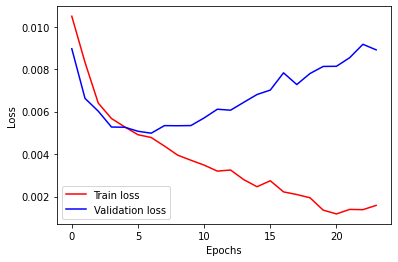

In [56]:

# plot learning curve based on loss
c = 0
epoch = np.arange(len(master_train_losses[c]))
plt.figure()
plt.plot(epoch, master_train_losses[c], 'r', epoch, master_val_losses[c], 'b')
plt.legend(['Train loss','Validation loss'])
plt.xlabel('Epochs'), plt.ylabel('Loss')
plt.show()



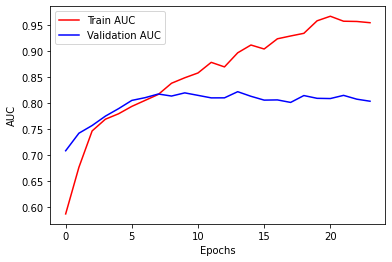

In [57]:

# plot learning curve based on AUC
epoch = np.arange(len(master_train_aucs[c]))
plt.figure()
plt.plot(epoch, master_train_aucs[c], 'r', epoch, master_val_aucs[c], 'b')
plt.legend(['Train AUC','Validation AUC'])
plt.xlabel('Epochs'), plt.ylabel('AUC')
plt.show()

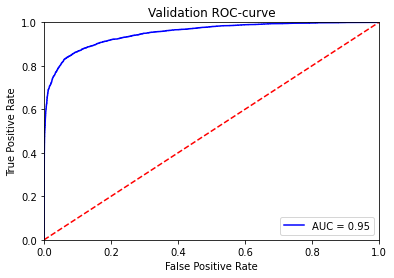

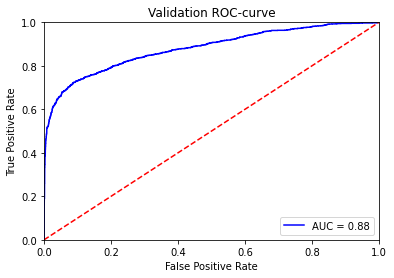

In [58]:
# plot AUC 
def plot_roc(targets, predictions, filename):
    """ function for plitting AUC """
    # ROC
    fpr, tpr, threshold = metrics.roc_curve(targets, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    # plot ROC
    plt.figure()
    plt.title('Validation ROC-curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# plot ROC-curve for concatenated results
best_train_targets_list_cat = sum(best_train_targets_list, [])
best_train_preds_list_cat = sum(best_train_preds_list, [])
best_val_targets_list_cat = sum(best_val_targets_list, [])
best_val_preds_list_cat = sum(best_val_preds_list, [])
best_train_preds_sig_list_cat = sum(best_train_preds_sig_list, [])
best_val_preds_sig_list_cat = sum(best_val_preds_sig_list, [])

plot_roc(best_train_targets_list_cat, best_train_preds_sig_list_cat, "train_AUC")
plot_roc(best_val_targets_list_cat, best_val_preds_sig_list_cat, "val_AUC")


In [59]:
## concatenated performance scores 

# f1 score 
print("F1 score of training", f1_score(best_train_targets_list_cat, best_train_preds_list_cat))
print("F1 score of validation", f1_score(best_val_targets_list_cat, best_val_preds_list_cat))

# confusion matrix
print("Confusion matrix for training", confusion_matrix(best_train_targets_list_cat, best_train_preds_list_cat))
print("Confusion matrix for validation", confusion_matrix(best_val_targets_list_cat, best_val_preds_list_cat))

# MCC 
print("MCC for training", matthews_corrcoef(best_train_targets_list_cat, best_train_preds_list_cat))
print("MCC for val", matthews_corrcoef(best_val_targets_list_cat, best_val_preds_list_cat))

F1 score of training 0.8187919463087249
F1 score of validation 0.7296908698777858
Confusion matrix for training [[12454   389]
 [ 1042  3233]]
Confusion matrix for validation [[3939  342]
 [ 410 1015]]
MCC for training 0.7693824614161995
MCC for val 0.6429576268706473
